Iteration 1/20
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20
Finished!
Iteration 1/20


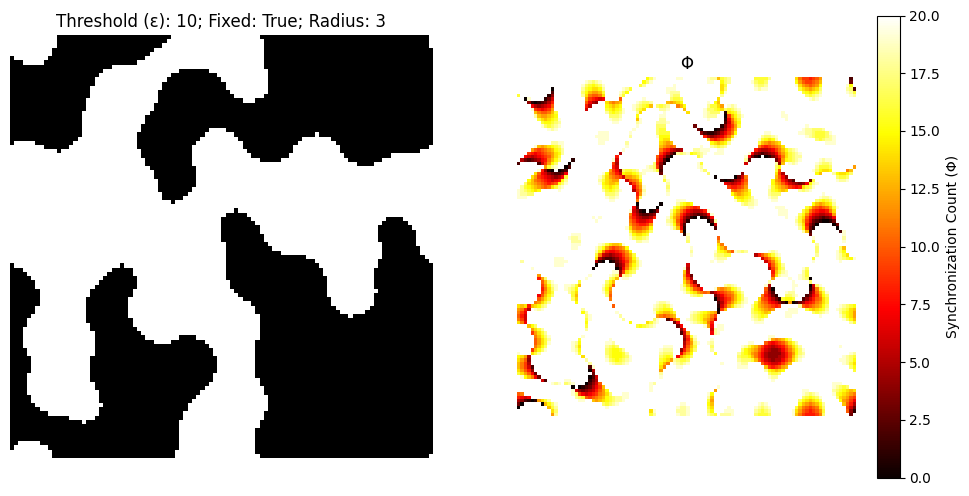

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def AND(inputs):
    return np.all(inputs == 1, axis=0).astype(int)

def OR(inputs):
    return np.any(inputs == 1, axis=0).astype(int)

def XOR(inputs):
    return (np.sum(inputs, axis=0) % 2).astype(int)
    


gates = [AND, OR, XOR]  # more interesting behavior without negation gates

# Compute entropy of the net
def H(S):
    counts = np.unique(S, return_counts=True)[1]
    p = counts / (N ** 2)
    return -np.sum(p * np.log(p))

# Parameters and conditions
N = 100  # smaller grid for better performance with distance calculations
N_iter = 20
S = np.random.choice((0, 1), size=(N, N))
fix = True
ε_fixed = 10
k = 4
Φ = np.zeros((N, N), dtype=int)
σ = 3  # standard deviation for the Gaussian function
radius = 3 # maximum distance for neighbor influence

# Dynamics for ε
def dynamics(*args, fixed=False):
    if fixed:
        return ε_fixed
    else:
        return int((N_iter * (1 - H(S))) / k)

ε = dynamics(fixed=fix)

# Gaussian weighting function
def gaussian_weight(d, sigma):
    return np.exp(-d**2 / (2 * sigma**2))

# Precompute distance weights within the radius
distance_weights = np.zeros((2 * radius + 1, 2 * radius + 1))
for i in range(-radius, radius + 1):
    for j in range(-radius, radius + 1):
        distance = np.sqrt(i**2 + j**2)
        if distance <= radius:
            distance_weights[i + radius, j + radius] = gaussian_weight(distance, σ)

# Initialize plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
mat1 = ax1.imshow(S, cmap="gray", vmin=0, vmax=1)
mat2 = ax2.imshow(Φ, cmap="hot", vmin=0, vmax=N_iter)
ax1.set_title(f"Threshold (ε): {ε}")
ax1.axis("off")
ax2.set_title("Φ")
ax2.axis("off")
cbar2 = fig.colorbar(mat2, ax=ax2)
cbar2.set_label("Synchronization Count (Φ)")

# Gate initialization
gate = np.random.choice(gates, (N, N))

def update(frame, *args):
    global S, Φ, ε, gate

    print(f"Iteration {frame + 1}/{N_iter}")

    if np.mean(Φ) >= ε:
        gate = np.random.choice(gates, (N, N))

    new_state = np.zeros_like(S)
    
    # Update each cell based on Gaussian-weighted influence from its neighbors
    for i in range(N):
        for j in range(N):
            weighted_sum = 0
            weight_total = 0
            
            for di in range(-radius, radius + 1):
                for dj in range(-radius, radius + 1):
                    ni, nj = (i + di) % N, (j + dj) % N
                    distance_weight = distance_weights[di + radius, dj + radius]
                    weighted_sum += S[ni, nj] * distance_weight
                    weight_total += distance_weight

            average_state = weighted_sum / weight_total if weight_total > 0 else 0
            new_state[i, j] = 1 if average_state >= 0.5 else 0

    sync = (new_state == S)
    Φ[sync] += 1
    Φ[~sync] = 0

    if np.any(Φ >= ε):
        ensemble_idxs = np.argwhere(Φ >= ε)
        for i, j in ensemble_idxs:
            for di in range(-radius, radius + 1):
                for dj in range(-radius, radius + 1):
                    ni, nj = (i + di) % N, (j + dj) % N
                    S[ni, nj] = new_state[i, j]

    ε = dynamics(fixed=fix)
    S = new_state
    mat1.set_array(S)
    mat2.set_array(Φ)

    ax1.set_title(f"Threshold (ε): {ε}; Fixed: {fix}; Radius: {radius}")
    return mat1, mat2

ani = FuncAnimation(fig, update, frames=N_iter, interval=500)
ani.save("euclidean_automaton_example.gif", writer="pillow", fps=10)
print("Finished!")
